# Image and Video Preprocessing or Augmentation

**With our prior expertise in computer vision based data, we have in-built support for [preprocessing or augmenting](https://docs.aperturedata.io/query_language/Reference/shared_command_parameters/operations) images, videos, and their regions of interest while storing or accessing them.**

In [1]:
from aperturedb.CommonLibrary import create_connector

# Create the connector for ApertureDB
client = create_connector()

In [2]:
from aperturedb.CommonLibrary import create_connector

# Create the connector for ApertureDB
client = create_connector()

In [3]:
# Simple query to see how the database is doing
# https://docs.aperturedata.io/query_language/Reference/db_commands/GetStatus
query = [{
    "GetStatus": {
    }
}]

# Execute the query to get back a JSON response for GetStatus 
response, blobs = client.query(query)

client.print_last_response()

[
    {
        "GetStatus": {
            "info": "OK",
            "status": 0,
            "system": "ApertureDB",
            "version": "0.17.23"
        }
    }
]


## Add a reformatted Image of a Dish to ApertureDB

**Original image is JPEG but let's say we want to add it as png**

In [4]:
query = [{
    "AddImage": {
        # Notice the missing "class" property since we already know its an Image (represented as _Image in ApertureDB)
        "properties": {
            "name": "Focaccia",
            "id": 35,
            "contributor": "Vishakha",
            "category": "starter",
            "cuisine": "Italian",
            "location": "Brittany",
            "caption": "fresh made focaccia with herbs from the garden"
        },
        "format": "png",
        "if_not_found": {                  # avoid adding twice
            "id": ["==", 35]
        }
    }
}]

# Read the image data as a binary blob
fd = open("data/focaccia_brittany.jpg", 'rb')
image_arr = [ fd.read() ]
fd.close()

response, blobs = client.query(query, image_arr)

client.print_last_response()

[
    {
        "AddImage": {
            "status": 0
        }
    }
]


## Now retrieve a thumbnail of the Food image

1


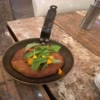

In [5]:
from aperturedb import NotebookHelpers as nh   # Our helper package for image displays and other utilities

query = [{
    "FindImage": {
        "constraints": {
            "name": ["==", "Focaccia"],
            "location": [">", "A"] 
        },
        "operations": [{
            "type": "resize",
            "width": 100,
            "height": 100
        } ],
        "as_format": "jpg",
        "blobs": True
    }
}]

response, blobs = client.query(query)

# Instead of using nh.display, which automatically reformats an image
# for display, we use IPython.display to show how its returned from the query.
from IPython.display import display,Image
num_images = response[0]["FindImage"]["returned"]
print(num_images)
for count in range(num_images):
    image = Image(blobs[count], format="JPEG")
    display(image)

## Videos can similarly be pre-processed when adding or searching

In [6]:
query = [{
    "AddVideo": {
        # Notice the missing "class" property since we already know its a Video (represented as _Video in ApertureDB)
        "properties": {
            "name": "crepe_flambe",
            "id": 45,
            "category": "dessert",
            "cuisine": "French",
            "location": "Brittany",
            "caption": "Special Brittany flambe crepe"
        },
        "if_not_found": {                  # avoid adding twice
            "id": ["==", 45]
        }
    }
}]

# Read the image data as a binary blob
fd = open("data/crepe_flambe.mp4", 'rb')
array = [ fd.read() ]
fd.close()

response, blobs = client.query(query, array)

client.print_last_response()

[
    {
        "AddVideo": {
            "status": 0
        }
    }
]


### Original video

In [ ]:
from aperturedb import NotebookHelpers as nh   # Our helper package for image displays and other utilities

query = [{
    "FindVideo": {
        "constraints": {
            "name": [">=", "crepe"],
            "location": [">", "A"] 
        },
        "blobs": True,                          # This is set to False by default
        "results": {
            "all_properties": True
        }
    }
}]

response, blobs = client.query(query)

client.print_last_response()
num_videos = response[0]["FindVideo"]["returned"]
for count in range(num_videos):
    nh.display_video_mp4(blobs[count])

### Sample and pre-process the cooking video when retrieving

In [8]:
query = [{
    "FindVideo": {
        "constraints": {
            "name": [">=", "crepe"],
            "location": [">", "A"]
        },
        "blobs": True,
        "operations": [{        # Original videos are longer. We just want to sample and prepare them
            "type": "resize",   # performance depends on the video complexity
            "height": 300,
            "width":  300
        },{
            "type": "interval", # Interval Operation, performance depends on the video complexity
            "start": 30,        # Start from 1 sec (30fps * 1)
            "stop": 150,        # Continue till 5 secs (30fps * 5)
            "step": 5           # Read every 5th frame
        }]
    }
}]

response, blobs = client.query(query)

print(client.get_last_response_str())
nh.display_video_mp4(blobs[0])

[
    {
        "FindVideo": {
            "blobs_start": 0,
            "returned": 1,
            "status": 0
        }
    }
]


## Cleanup

In [9]:
query = [{
    "DeleteVideo": {
        "constraints": {
            "name": ["==", "crepe_flambe"]     # if this matches multiple videos, they will all be deleted
        }
    }
},{
    "DeleteImage": {
        "constraints": {
            "name": ["==", "Focaccia"]
        }
    }
}]

response, blobs = client.query(query)

client.print_last_response()

[
    {
        "DeleteVideo": {
            "count": 1,
            "status": 0
        }
    },
    {
        "DeleteImage": {
            "count": 1,
            "status": 0
        }
    }
]
